<a href="https://colab.research.google.com/github/Andrew-Helmer/pmj-cpp/blob/master/analyses/PMJ(0%2C2)_Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np

from cycler import cycler
default_cycler = (cycler(color=['steelblue', 'darkred', 'darkgreen', 'magenta', 'tomato', 'cornflowerblue', 'gold']))
plt.rc('axes', prop_cycle=default_cycler)

In [0]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

First we just read the analysis python file from GitHub.

In [0]:
import urllib
def read_file_from_url(url):
  request = urllib.request.Request(url, headers=default_headers)
  file = urllib.request.urlopen(request)
  return file.read().decode("utf-8")

In [0]:
url = 'https://raw.githubusercontent.com/Andrew-Helmer/pmj-cpp/master/analyses/error_analysis.py'
# This creates a dictionary called "analyses"
exec(read_file_from_url(url))

And now generate some cool graphs from it.

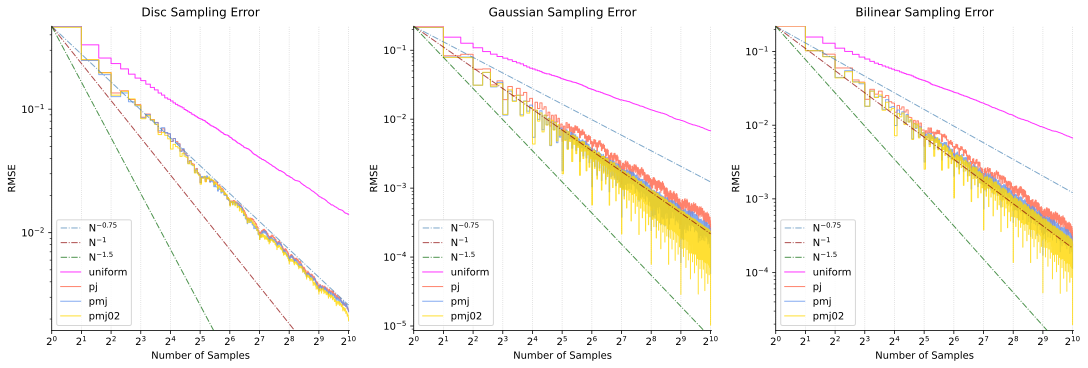

In [6]:
#@title
import math

n_cols = 3
n_rows = math.ceil(len(analyses)/n_cols)
fig = plt.figure(constrained_layout=True, figsize=(n_cols*5, 5*n_rows))
grid_spec = gridspec.GridSpec(ncols=n_cols, nrows=n_rows, figure=fig)

for i, distribution in enumerate(analyses):
  analysis = analyses[distribution]
  ax = fig.add_subplot(grid_spec[i//n_cols, i%n_cols])
  ax.set_xscale('log', basex=2)
  ax.set_yscale('log', basey=10)
  ax.set_xlabel("Number of Samples")
  ax.set_ylabel("RMSE")
  ax.set_title("{0} Sampling Error".format(distribution.capitalize()), pad=10)

  first_alg = next(iter(analysis.keys()))
  first_errors = next(iter(analysis.values()))
  first_error = first_errors[0]

  ax.xaxis.set_major_locator(plt.LogLocator(2, numticks=20))

  clip = 0
  x = range(clip+1, len(first_errors)+1)

  sqrt_x = first_error*np.power(x, -0.75)
  ax.plot(x, sqrt_x, label='N$^{-0.75}$', linewidth=1, linestyle='-.', alpha=0.7, zorder=3)
  x_minus_1 = first_error*np.power(x, -1.0)
  ax.plot(x, x_minus_1, label='N$^{-1}$', linewidth=1, linestyle='-.', alpha=0.7, zorder=3)
  x_minus_15 = first_error*np.power(x, -1.5)
  ax.plot(x, x_minus_15, label='N$^{-1.5}$', linewidth=1, linestyle='-.', alpha=0.7, zorder=3)

  min_error = 1.0
  for algorithm, errors in analysis.items():
    if 'bn' in algorithm:
      continue
    errors = errors[clip:]
    min_error = min(min_error, errors[-1])
    
    ax.step(x, errors, label=algorithm, linewidth=1, alpha=0.8, zorder=2, where='post')

  ax.set_ylim(ymax=first_error, ymin=min_error/1.2)
  ax.set_xlim(xmin=1, xmax=len(x)*1.02)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  ax.grid(True, axis='x', linestyle='dotted', color='lightgray', zorder=1)
  ax.legend(loc='lower left')

# Uncomment this to save the file.
# plt.savefig("error_analysis.svg")
plt.show()

If we want to, say, compare the ratios of errors for different distributions, we can do that too.

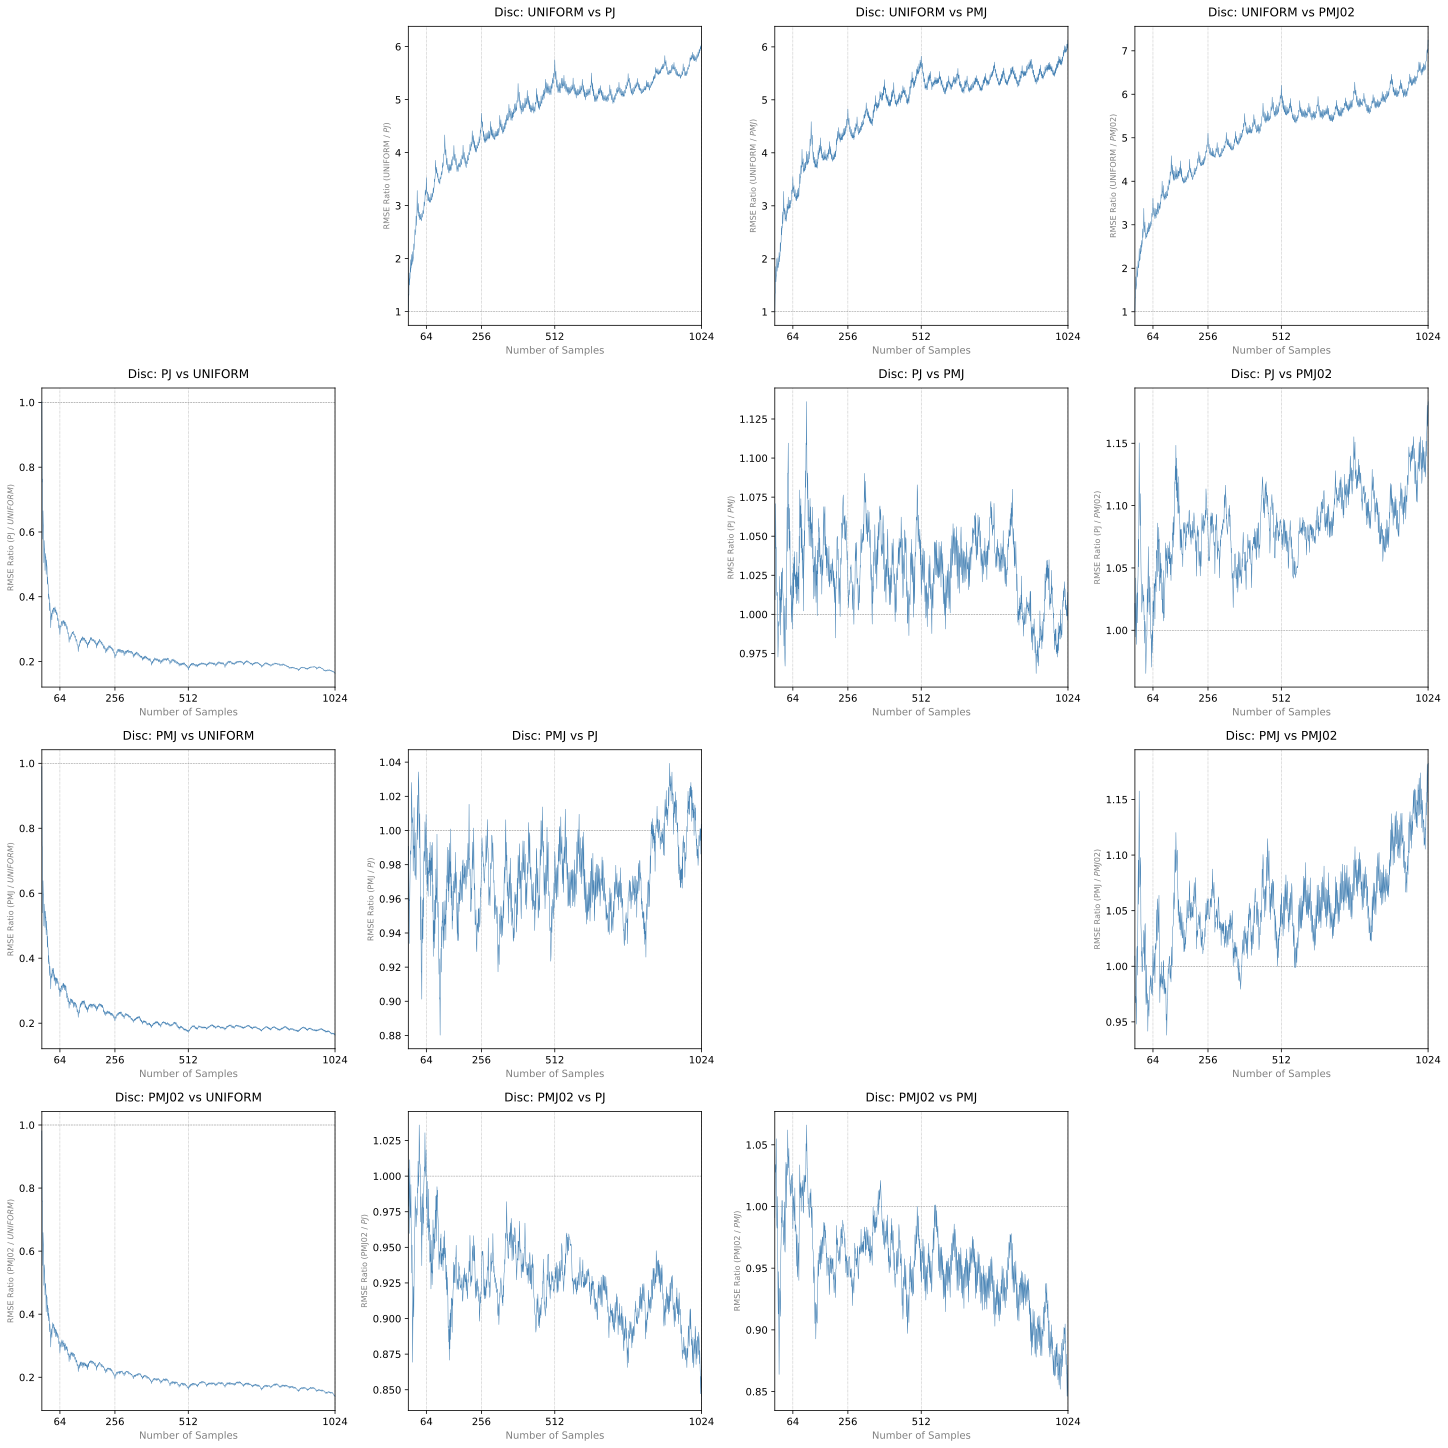

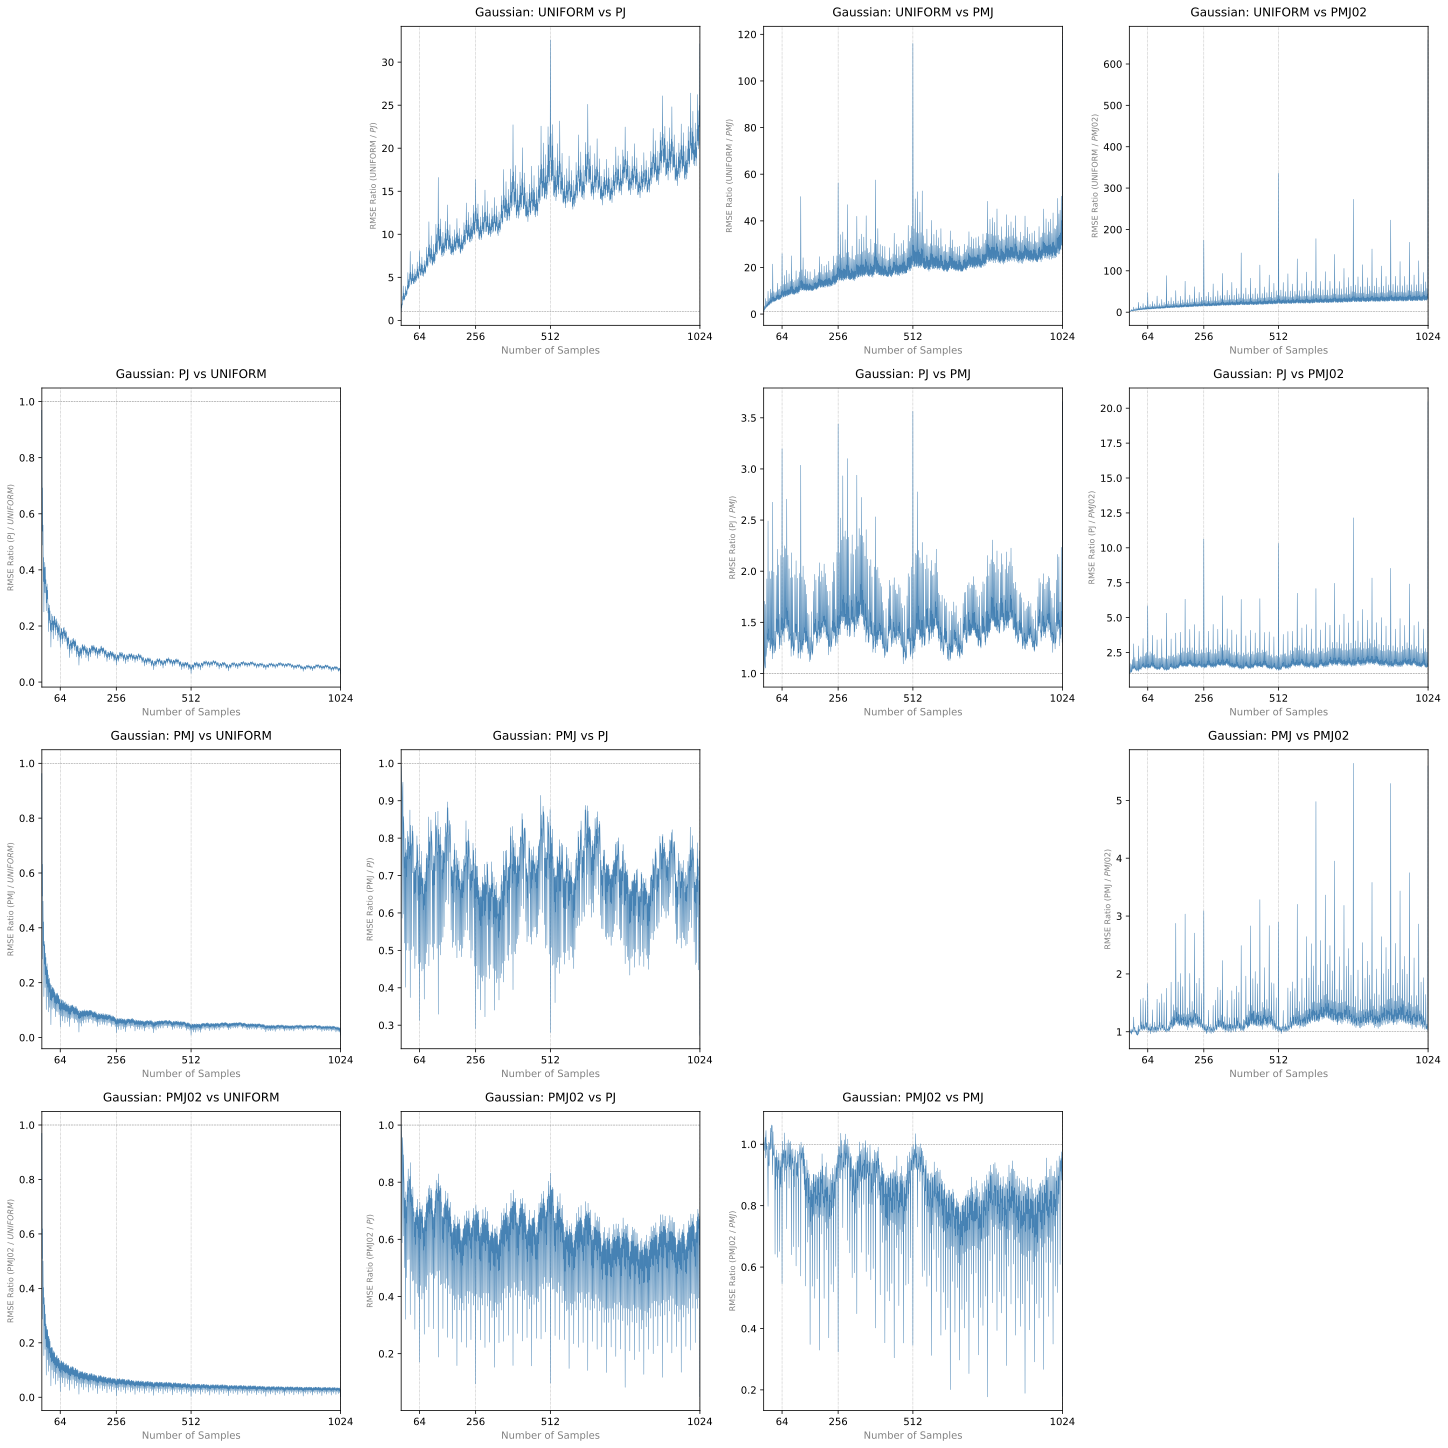

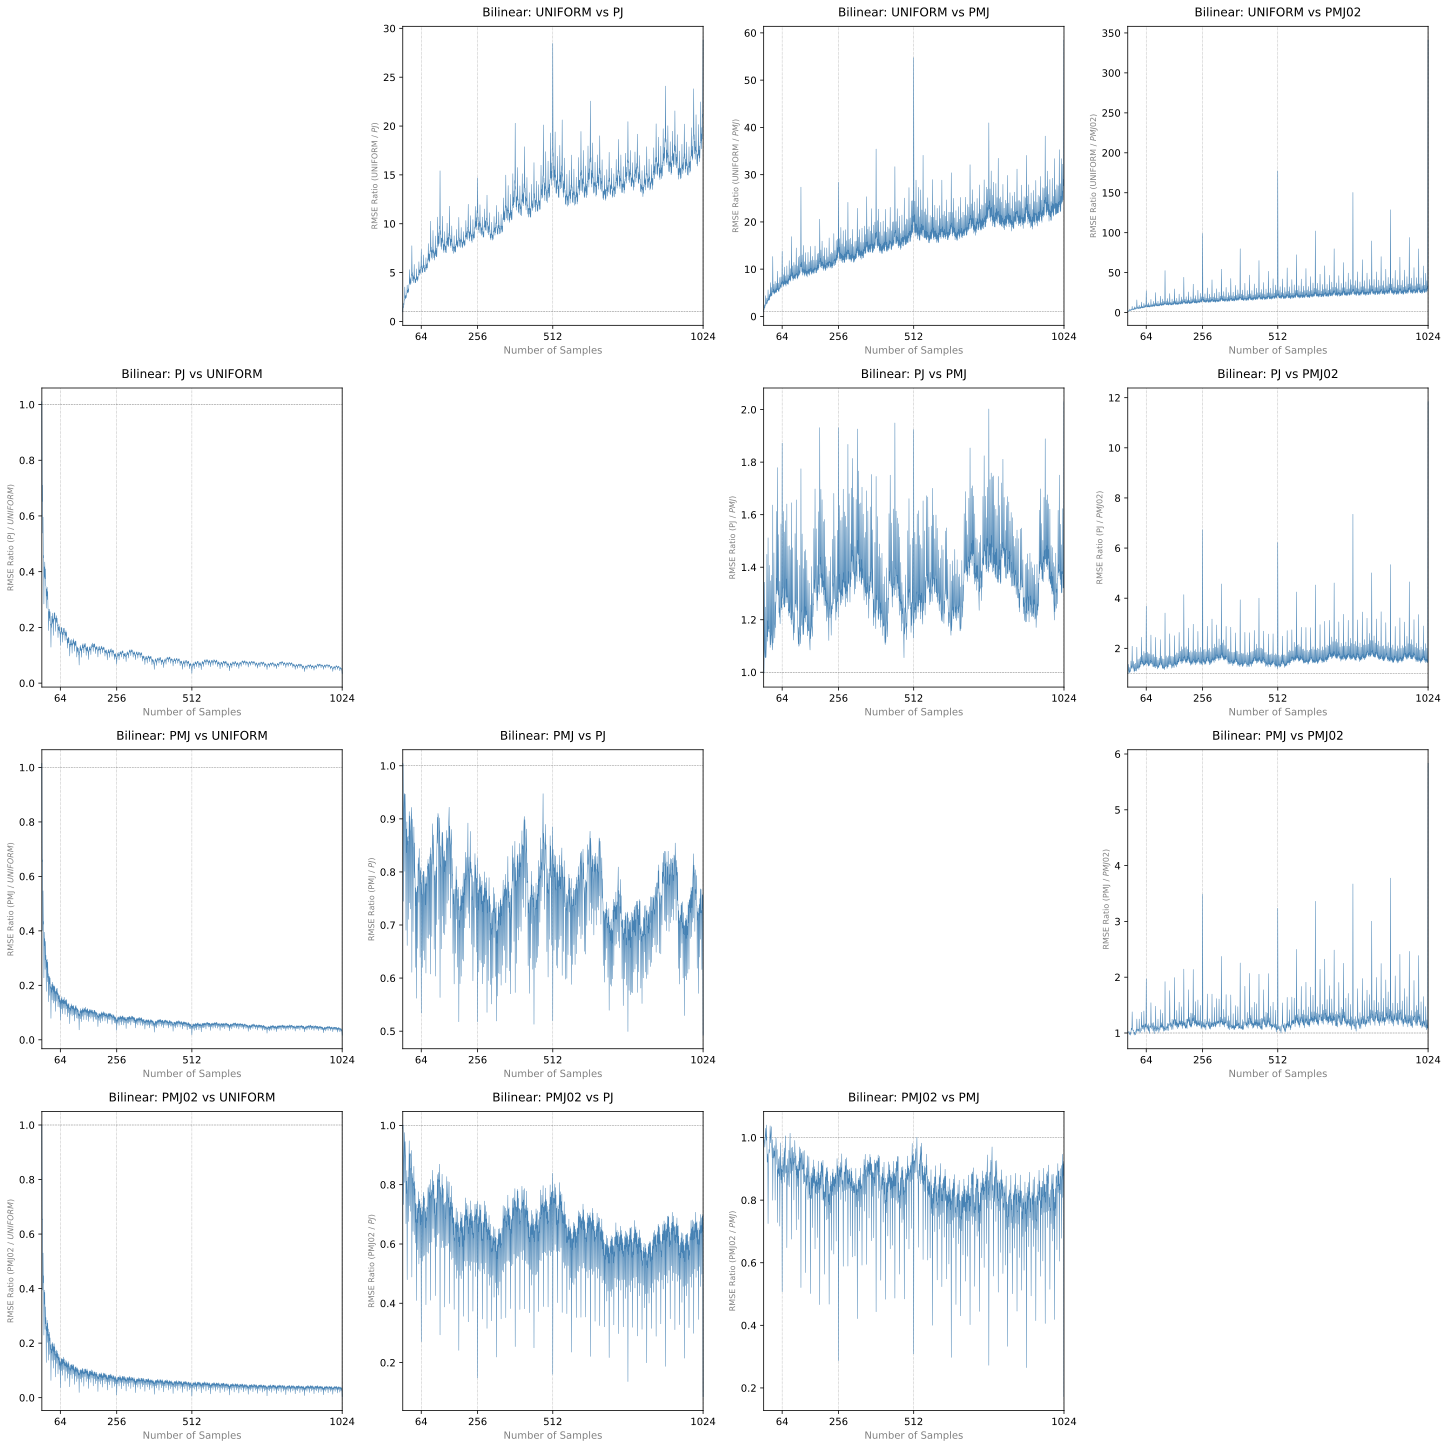

In [7]:
#@title
from itertools import combinations

def moving_average(a, n=32) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for distribution, analysis in analyses.items():
  algorithms = list(analysis.keys())
  fig = plt.figure(constrained_layout=True, figsize=(5*len(algorithms), 5*len(algorithms)))
  grid_spec = gridspec.GridSpec(ncols=len(algorithms), nrows=len(algorithms), figure=fig)
  for (i, j) in combinations(range(len(algorithms)), 2):
    for (idx1, idx2) in [(i, j), (j, i)]:
      algo1 = algorithms[idx1]
      algo2 = algorithms[idx2]

      error_avg1 = np.array(analysis[algo1])
      error_avg2 = np.array(analysis[algo2])
      error_diffs = moving_average(error_avg1 / error_avg2, n=1)

      ax = fig.add_subplot(grid_spec[idx1, idx2])
      ax.set_xticks([64, 256, 512, 1024, 2048])
      ax.set_xlim(1, len(error_diffs))
      ax.axhline(1.0, linestyle='--', color='gray', linewidth=0.5)
      # ax.set_xscale('log', basex=2)
      ax.set_xlabel("Number of Samples", size=10, c='gray')
      ax.set_ylabel("RMSE Ratio $( ${0} / ${1} )$".format(algo1.upper(), algo2.upper()), size=8, c='gray')
      plt.title("{0}: {1} vs {2}".format(distribution.capitalize(), algo1.upper(), algo2.upper()), pad=10, size=12)

      x = range(1, len(error_diffs)+1)
      ax.plot(x, error_diffs, linewidth=0.5, c='steelblue')
      ax.grid(True, axis='x', linewidth=0.5, linestyle='dotted', c='gray')
      ax.grid(False, axis='y')

  plt.show()